# **Neural Style Transfer**

---


This notebook is the implementation of [Neural-Style-Algorithm](https://arxiv.org/abs/1508.06576) 

The algorithm takes three images, an input image, a content-image, and a style-image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

### Underlying principle:
* We define 2 distances:
  1. **Content Distance** ($D_C$): Measures how different the content is between 2 images
  2. **Style distance** ($D_S$): Measures how different the style is between 2 images
* Then, we take the input image and transform it to minimize both its $D_C$ with the content-image and its $D_S$ with the style-image

### Importing packages

In [1]:
from __future__ import print_function

import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

import copy

%matplotlib inline

In [2]:
# select GPU if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:: ", device)

device::  cuda


### Loding the images
Import the content and style images. The images need to be resized to have same dimentions

In [3]:
def im_crop_center(img):
    img_width, img_height = img.size
    w = h = min(img_width, img_height)
    left, right = (img_width - w) / 2, (img_width + w) / 2
    top, bottom = (img_height - h) / 2, (img_height + h) / 2
    left, top = round(max(0, left)), round(max(0, top))
    right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
    return img.crop((left, top, right, bottom))

In [4]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256    # use small size for CPU
loader = transforms.Compose([
              transforms.Resize(imsize),
              transforms.ToTensor()
          ])

In [21]:
def image_loader(image_name):
  image = Image.open(image_name)
  image = im_crop_center(image,)
  # fake batch dimension required to fit network's input dimensions
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

In [113]:

style_img = image_loader('/content/images/sstyle-1.jpg')
content_img = image_loader('/content/images/ronaldo.jpg')

assert style_img.size() == content_img.size(), "Import style image and content image of same size"

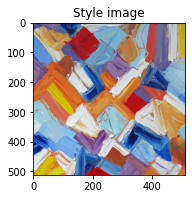

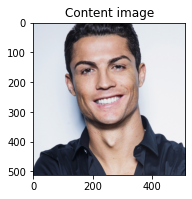

In [114]:
# display the content and style images

unloader = transforms.ToPILImage()  
plt.ion()

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

plt.figure()
plt.subplot(1, 2, 1)
imshow(style_img, 'Style image')

plt.figure()
plt.subplot(1, 2, 2)
imshow(content_img, 'Content image')

### Loss functions

#### Content Loss
input: 
* $F_{XL}$ (Feature maps of the input image $X$ in layer $L$)
* $F_{CL}$ (Feature maps of the content image $C$ in layer $L$)

content distance:
* $D_C^L(X,C)$ =  $\|F_{XL} - F_{CL}\|^2$

output: 
<!-- * returns layer $L$'s input) -->
* returns $W_{CL}.D_C^L(X,C)$ (Weighted content distance between input image $X$ and the content image $C$)

In [24]:
# content loss

class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    # we 'detach' the target content from the tree used to dynamically compute the gradient: 
      # this is a stated value, not a variable. 
          # Otherwise the forward method of the criterion will throw an error.
    self.target = target.detach()

  # to make the content loss layer transparent we must define a forward method 
  def forward(self, input):
    # mse_loss = nn.MSELoss()
    # loss_out = mse_loss(input, self.target)
    # both are the same implementation of MSELoss()
    self.loss = F.mse_loss(input=input, target=self.target)
    return input

#### Style Loss

input:
* $F_{XL}$ (*Feature* maps of the input image $X$ in layer $L$ which is reshaped to form $\hat{F}_{XL_{(K,N)}}$

 where, 
  * $K$: the number of feature maps at layer $L$
  * $N$ is the length of any vectorized feature map $F_{XL}^k$. 

  For example, the first line
of $\hat{F}_{XL}$ corresponds to the first vectorized feature map $F_{XL}^1$.

Gram product:

> *A gram matrix is the result of multiplying a given matrix by its transposed matrix*

* $G$ = $\hat{F}_{XL}$.$\hat{F}_{XL}^T$
* The gram matrix must be normalized by dividing each element by the total number of elements in the matrix. 
*This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$ dimension yield larger values in the Gram matrix.
* These larger values will cause the
first layers (before pooling layers) to have a larger impact during the
gradient descent. 
* Style features tend to be in the deeper layers of the
network so this normalization step is crucial.

output:
* Normalized gram product $G$

style distance:
* $D_S^L(X,S)$ =  $\|G_{XL} - G_{SL}\|^2$



In [25]:
# style loss

def gram_matrix(input):
  a, b, c, d = input.size()   # a=batch_size(=1), b=num of feature maps, (c,d)=dim of a feature map (N=c*d)
  features = input.view(a*b, c*d) # resise F_XL into \hat F_XL
  G = torch.mm(features, features.t())  # compute the gram product
  # normalize the values of the gram matrix by dividing by the number of elements in each feature maps.
  return G.div(a * b * c * d)


In [26]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(input=G, target=self.target)
    return input

### Importing the model

Import VGG19 model.

PyTorch’s implementation of VGG is a module divided into two child ```Sequential``` modules: 
* ```features```: contains convolution and pooling layers
* ```classifier```: contains fully connected layers

Use the ```features``` module because the output of the individual convolution layers is needed to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [27]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()
print("cnn:: ", cnn)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



cnn::  Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18)

In [28]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
    # normalize the image
    return (img - self.mean) / self.std

Add the content loss and style loss layers immediately after the convolution layer they are detecting. To do this create a new Sequential module that has content loss and style loss modules correctly inserted.

In [92]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)

  # normalization module
  normalization = Normalization(normalization_mean, normalization_std).to(device)

  content_losses = []
  style_losses = []

  model = nn.Sequential(normalization)

  i = 0     # increment every time we see a conv
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    if name in content_layers:
      # add content loss
      target = model(content_img).detach()
      content_loss = ContentLoss(target=target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      # add style loss
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature=target_feature)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)
  #now we trim off the layers after the last style and content losses
 
  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses

In [93]:
model, style_losses, content_losses = get_style_model_and_losses(cnn,
                      cnn_normalization_mean, cnn_normalization_std, style_img, content_img)
model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_2): ContentLoss()
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

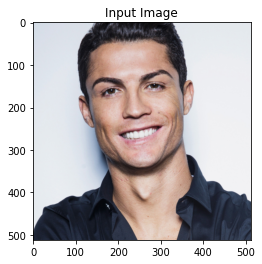

In [115]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Gradient descent
As Leon Gatys, the author of the algorithm, suggested [here](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/18), ```L-BFGS``` algorithm is used in this notebook to run gradient descent. Unlike training a network, here, the input image is trained in order to minimise the content/style losses.

In [116]:
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_(True)], lr=0.1)
  return optimizer

### Running the style transfer
The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [117]:

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, total_steps=512,
                       style_weight=1000000, content_weight=1, print_every=100):
  print("Building the style transfer model...")
  model, style_losses, content_losses = get_style_model_and_losses(cnn,
                      normalization_mean, normalization_std, style_img, content_img)

  optimizer = get_input_optimizer(input_img)
  print("Optimizing...")
  run = [0]

  while run[0] <= total_steps:
    def closure():
      # correct the values of updated input image
      input_img.data.clamp_(0, 1)

      optimizer.zero_grad()
      model(input_img)
      style_score = 0
      content_score = 0
      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss

      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()

      run[0] += 1
    
      if run[0] % print_every == 0:
        print("run {}:".format(run))
        print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(), content_score.item()))
        print()
      return style_score + content_score
    optimizer.step(closure)
  # a last correction...
  input_img.data.clamp_(0, 1)
  return input_img

In [118]:
# hyperparameters
total_steps=1024
style_weight=1000000
content_weight=1
print_every = 500

Building the style transfer model...
Optimizing...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


run [100]:
Style Loss : 575.312988 Content Loss: 1.861481

run [200]:
Style Loss : 98.517372 Content Loss: 3.006896

run [300]:
Style Loss : 28.323023 Content Loss: 3.606157

run [400]:
Style Loss : 8.000859 Content Loss: 3.955349

run [500]:
Style Loss : 2.525884 Content Loss: 4.098635

run [600]:
Style Loss : 1.196756 Content Loss: 4.037673

run [700]:
Style Loss : 0.717766 Content Loss: 3.911764

run [800]:
Style Loss : 0.529461 Content Loss: 3.791158

run [900]:
Style Loss : 0.438271 Content Loss: 3.692579

run [1000]:
Style Loss : 0.377705 Content Loss: 3.613683



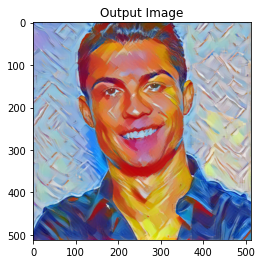

In [119]:

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, total_steps)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [ ]:
out_img = output[0]
save_image(out_img, './transfer_image4.png')